In [68]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import time
from scipy.integrate  import ode, solve_ivp

In [2]:
#Code Credits: Videh Patel 

def DH2HnJ(Hmat, prismatic=[]):
    #Hmat is the DH parameter matrix
    #prismatic is an array of the joints that are prismatic: Joint corresponding to qi is ith joint
    #All revolute and prismatic axes are assumed to be aligned with the respective z axis

    def d_(k):
        #Returns position vector of ee wrt k-frame in o-frame basis
        return (T[k][:3,:3])@(np.linalg.inv(T[k])@T[n]@(np.matrix([[0],[0],[0],[1]])))[:3,0]
        
    n = len(Hmat)
    T = [np.matrix([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])]  #Array of all absolute Homogeneous Transformations : Has T0_0 at the start (Identity matrix)
    J = []  #Manipulator Jacobian
    for params in Hmat:
        theta, d, a, alpha = np.array(params)[0]
        Ti = np.matrix([ [ np.cos(theta), -np.sin(theta)*np.cos(alpha), np.sin(theta)*np.sin(alpha), a*np.cos(theta)],\
                         [ np.sin(theta), np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],\
                         [ 0            , np.sin(alpha)               , np.cos(alpha)              , d              ],\
                         [ 0            , 0                           , 0                          ,1              ] ])
        

        T.append(T[-1]@Ti)

    for i in range(n):
        if (i+1) in prismatic:
            Jv = T[i][:3,:3]@np.matrix([0,0,1]).T
            Jw = np.matrix([0,0,0]).T
        else: #Revolute
            Jw = T[i][:3,:3]@np.matrix([0,0,1]).T
            Jv = np.matrix(np.cross(Jw.T,d_(i).T).T)
        
        Ji = np.concatenate((Jv, Jw))
        
        if len(J) == 0:
            J = Ji
        else:
            J = np.concatenate((J,Ji), axis = 1)

        H = T[n]

    return H

#Implementation of PUMA Dynamics and Control


In [3]:
def PUMA_invkin(p, dimensions):
  l1, l2, l3 = dimensions
  x, y, z = p

  theta1 = np.arctan(y/x)
  D = (x**2 + y**2 + (z - l1)**2  - l2**2 - l3**2)/(2*l2*l3)
  theta3 = np.arccos(D)
  theta2 = np.arctan((z - l1)/np.sqrt(x**2 + y**2)) - np.arctan(l3*np.sin(theta3)/(l2 + l3*np.cos(theta3)))

  return theta1, theta2, theta3
  
def PUMA_forwkin(q, dimensions):
  q1, q2, q3 = q
  l1, l2, l3 = dimensions
  
  Dh = np.matrix([[q1, l1, 0, -np.pi/2],[q2 , 0, l2, 0],[q3 , 0, l3, 0]])
  H = DH2HnJ(Dh,[])

  return H[0, -1], H[1, -1], H[2, -1]

In [4]:
def PUMA_Dmat(m, l):
  m1, m2, m3 = m
  l1, l2, l3 = l
  q1 = sym.Symbol('q1')
  q2 = sym.Symbol('q2')
  q3 = sym.Symbol('q3')
  q1_dot = sym.Symbol('q1_dot')
  q2_dot = sym.Symbol('q2_dot')
  q3_dot = sym.Symbol('q3_dot')
  q1_dotdot = sym.Symbol('q1_dotdot')
  q2_dotdot = sym.Symbol('q2_dotdot')
  q3_dotdot = sym.Symbol('q3_dotdot')

  Jvc1 = np.array([[0, 0, 0],
                   [0, 0, 0], 
                   [0, 0, 0]])
  Jw1 = np.array([[0, 0, 0], 
                  [0, 0, 0],
                  [1, 0, 0]])
  
  Jvc2 = np.array([[(-l2/2)*sym.sin(q1)*sym.cos(q2), (-l2/2)*sym.cos(q1)*sym.sin(q2), 0],
          [(l2/2)*sym.cos(q1)*sym.cos(q2), (-l2/2)*sym.sin(q1)*sym.sin(q2), 0],
          [0, (l2/2)*sym.cos(q2), 0]])
  Jw2 = np.array([[0, 0, 0],
         [0, 1, 0],
         [1, 0, 0]])
  
  Jvc3 = np.array([[-l2*sym.sin(q1)*sym.cos(q2) - (l3/2)*sym.sin(q1)*sym.cos(q3 + q2), -l2*sym.cos(q1)*sym.sin(q2) - (l3/2)*sym.sin(q3 + q2)*sym.cos(q1), (-l3/2)*sym.sin(q3 + q2)*sym.cos(q1)],
                  [l2*sym.cos(q1)*sym.cos(q2) + (l3/2)*sym.cos(q1)*sym.cos(q3 + q2), -l2*sym.sin(q1)*sym.sin(q2) - (l3/2)*sym.sin(q3 + q2)*sym.sin(q1), (-l3/2)*sym.sin(q3 + q2)*sym.sin(q1)],
                  [0, l2*sym.cos(q2) + (l3/2)*sym.cos(q2+q3), (l3/2)*sym.cos(q2+q3)]])
  Jw3 = np.array([[0, 0, 0],
         [0, 1, 1],
         [1, 0, 0]])
  
  D = m1*Jvc1.T*Jvc1 + m2*Jvc2.T*Jvc2 + m3*Jvc3.T*Jvc3 #+ Jw1.T*R1*I1*R1.T*Jw1  + Jw2.T*R2*I2*R2.T*Jw2 + Jw3.T*R3*I3*R3.T*Jw3

  return D

#print(PUMA_Dmat([2,2,2],[0.5,0.3,0.3]))

In [143]:
def PUMA_dynamic_equation(m, l):
  l1, l2, l3 = l
  m1, m2, m3 = m
  q1 = sym.Symbol('q1')
  q2 = sym.Symbol('q2')
  q3 = sym.Symbol('q3')
  q = np.array([[q1], [q2], [q3]])
  q1_dot = sym.Symbol('q1_dot')
  q2_dot = sym.Symbol('q2_dot')
  q3_dot = sym.Symbol('q3_dot')
  q_dot = np.array([[q1_dot], [q2_dot], [q3_dot]])
  q1_dotdot = sym.Symbol('q1_dotdot')
  q2_dotdot = sym.Symbol('q2_dotdot')
  q3_dotdot = sym.Symbol('q3_dotdot')
  q_dotdot = np.array([[q1_dotdot], [q2_dotdot], [q3_dotdot]])
  g = 9.8

  n = 3

  D = PUMA_Dmat(m, l)
  
  V = m1*g*l1/2 + m2*g*(l1 + ( l2*sym.sin(q2))/2) + m3*g*(l1 + l2*sym.sin(q2) + (l3/2)*sym.sin(q2 + q3))

  G = np.array([[sym.diff(V, q1)],
                [sym.diff(V, q2)],
                [sym.diff(V, q3)]])
  
  C = [0]*n

  for k in range(n):
    for j in range(n):
      for i in range(n):
        C[k]  = (sym.diff(D[k][j], q[i][0]) + sym.diff(D[k][i], q[j][0]) - sym.diff(D[i][j], q[k][0]))
        C[k] = C[k]/2

  C = np.array(C)

  dynamic_eqn = sym.Array(D@q_dotdot + C@q_dot + G) #np.matmul(D,q_dotdot) + np.matmul(C,q_dot) + G
  return dynamic_eqn, D, C, G

#eqn, D, C, G = PUMA_dynamic_equation([2,2,2],[0.5,0.3,0.3])

In [142]:
def PUMA_invdynamics(m, l, q, q_dot, torques):
  q1, q2, q3 = q
  q1_dot, q2_dot, q3_dot = q_dot

  eqn, D, C, G = PUMA_dynamic_equation(m, l)

  eqn_numbers = eqn.subs([('q1',q1), ('q2',q2), ('q3',q3), ('q1_dot', q1_dot), ('q2_dot',q2_dot), ('q3_dot',q3_dot)])
  #print(eqn_numbers)

  D_numbers = np.array([[eqn_numbers[0,0].coeff('q1_dotdot'), eqn_numbers[0,0].coeff('q2_dotdot'), eqn_numbers[0,0].coeff('q3_dotdot')],
                [eqn_numbers[1,0].coeff('q1_dotdot'), eqn_numbers[1,0].coeff('q2_dotdot'), eqn_numbers[1,0].coeff('q3_dotdot')],
                [eqn_numbers[2,0].coeff('q1_dotdot'), eqn_numbers[2,0].coeff('q2_dotdot'), eqn_numbers[2,0].coeff('q3_dotdot')]], dtype = 'float')
  #print(D_numbers)
  
 # M = C@q_dot + G
 # K = eqn_numbers - D@np.array([['q1_dotdot'],['q2_dotdot'],['q3_dotdot']])
  K = np.array([[((eqn_numbers[0,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[1,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[2,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)]])
  #print(K)
  D_inv = np.linalg.inv(D_numbers)
  M = np.array([[torques[0] - K[0,0]],
                [torques[1] - K[1,0]],
                [torques[2] - K[2,0]]])
  #print(D_inv)
  #print(M)
  q_dotdot = np.array(D_inv@M, dtype = 'float')
  #print(q_dotdot)
  return [q_dotdot[0,0], q_dotdot[1,0], q_dotdot[2,0]]

#PUMA_invdynamics([2,2,2], [0.5,0.3,0.3], [0.4,0.4,0.4],[0.1,0.1,0.1], [3,4,5])

In [36]:
def dummy_PUMA_invdynamics(t, y):
  #m = [2, 2, 2]
  #l = [0.5, 0.3, 0.3]
  q1, q2, q3 = y[0], y[2], y[4]
  q1_dot, q2_dot, q3_dot = y[1], y[3], y[5]

  eqn, D, C, G = PUMA_dynamic_equation(m, l)

  eqn_numbers = eqn.subs([('q1',q1), ('q2',q2), ('q3',q3), ('q1_dot', q1_dot), ('q2_dot',q2_dot), ('q3_dot',q3_dot)])
  #print(eqn_numbers)

  D_numbers = np.array([[eqn_numbers[0,0].coeff('q1_dotdot'), eqn_numbers[0,0].coeff('q2_dotdot'), eqn_numbers[0,0].coeff('q3_dotdot')],
                [eqn_numbers[1,0].coeff('q1_dotdot'), eqn_numbers[1,0].coeff('q2_dotdot'), eqn_numbers[1,0].coeff('q3_dotdot')],
                [eqn_numbers[2,0].coeff('q1_dotdot'), eqn_numbers[2,0].coeff('q2_dotdot'), eqn_numbers[2,0].coeff('q3_dotdot')]], dtype = 'float')
  #print(D_numbers)
  
 # M = C@q_dot + G
 # K = eqn_numbers - D@np.array([['q1_dotdot'],['q2_dotdot'],['q3_dotdot']])
  K = np.array([[((eqn_numbers[0,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[1,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[2,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)]])
  #print(K)
  D_inv = np.linalg.inv(D_numbers)
  M = np.array([[torques[0] - K[0,0]],
                [torques[1] - K[1,0]],
                [torques[2] - K[2,0]]])
  #print(D_inv)
  #print(M)
  q_dotdot = np.array(D_inv@M, dtype = 'float')
  #print(q_dotdot)
  return [q_dot[0], q_dotdot[0,0], q_dot[1], q_dotdot[1,0], q_dot[2], q_dotdot[2,0]]


q =  [0.7853981633974483, -1.1138622802514613, 1.3467032344935257]
qd =  [0.982793723247329, -1.1679944725267064, 1.7948894190962674]
0


/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


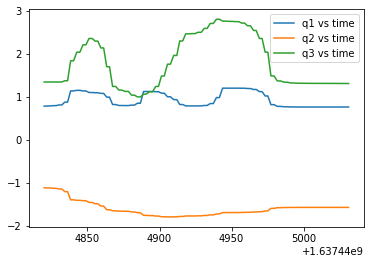

In [61]:
#def PI_Control(A, B):
l1, l2, l3 = 0.5, 0.3, 0.3
m1, m2, m3 = 2, 2, 2
A = [0.3, 0.3, 0.3]
B = [0.2 , 0.3, 0.4]
l = [l1, l2, l3]
m = [m1, m2, m3]

q1_A, q2_A, q3_A = PUMA_invkin(A, l)
q1_B, q2_B, q3_B = PUMA_invkin(B, l)

q = [q1_A, q2_A, q3_A]
qd = [q1_B, q2_B, q3_B]
print('q = ', q)
print('qd = ', qd)

q_dot = [0, 0, 0]

kp = 100
ki = 50

ode_eqn = ode(dummy_PUMA_invdynamics).set_integrator('vode', nsteps=5, method='bdf')
ode_eqn.set_initial_value([q1_A, 0, q2_A, 0, q3_A, 0], t = 0)
print(ode_eqn.t)
torques = np.array([0, 0, 0])
del_t = 0
loop = 0
q_all1 = []
q_all2 = []
q_all3 = []
q_dot_all1 = []
q_dot_all2 = []
q_dot_all3 = []
time_list = []
while (abs(qd[0] - q[0])>0.001) and (abs(qd[1] - q[1])>0.001) and (abs(qd[2] - q[2])>0.001):
  t = time.time()
  time_list.append(t)

  E = np.array(qd) - np.array(q)
  torques = kp*E + ki*E*del_t

  q_dotdot = PUMA_invdynamics(m, l, q, q_dot, torques)
  q[0], q_dot[0], q[1], q_dot[1], q[2], q_dot[2] = ode_eqn.integrate(ode_eqn.t+1) #DOUBT: ISME TIME KI ARGUMENT ME KYA DAALU?
  #print(q, q_dot)
  q_all1.append(q[0])
  q_all2.append(q[1])
  q_all3.append(q[2])
  q_dot_all1.append(q_dot[0])
  q_dot_all2.append(q_dot[1])
  q_dot_all3.append(q_dot[2])
  

  del_t = time.time() - del_t
  loop = loop + 1
  if loop>100:
    break

plt.plot(time_list, q_all1, label = 'q1 vs time')
plt.plot(time_list, q_all2, label = 'q2 vs time')
plt.plot(time_list, q_all3, label = 'q3 vs time')
plt.legend()

# Implementation of SCARA Dynamics and Control

In [130]:
def SCARA_invkin(p, dimensions):
    #Takes Transformation Matrix T and SCARA Manipulator (with shperical wrist) Dimensions as input and
    #returns joint params for a Stanford Manipulator to achieve the given position (Transformation Matrix)

    #dimensions is an array of form [l1, l2, l4, l5, l6]---> Link lengths
    ##Refer to pdf to look which link length corresponds to which

    l1, l2 = dimensions

    #Position of wrist centre
    x,y,z = np.array(p)

    #Inverse Position of wrist centre
    #First 3 params
    q2 = np.arccos((x*x + y*y - l1**2 - l2**2)/(2*l1*l2))
    q1 = np.arctan2(y,x) - np.arctan(l2*np.sin(q2)/(l1 + l2*np.cos(q2)))
    d3 = -z + l1
    if d3 < 0:
        print('Point out of workspace')
        return None

    return q1, q2, d3

def SCARA_forwkin(q, dimensions):
    q1, q2, d3 = q
    l1, l2 - dimensions

    Dh = np.matrix([[q1, l1, l1, 0],
                    [q2, 0, l2, np.pi],
                    [0, d3, 0, 0]])
    H = DH2HnJ(Dh,[2])

    return H[0, -1], H[1, -1], H[2, -1]

In [139]:
def SCARA_Dmat(m, l):
  m1, m2, m3 = m
  l1, l2 = l
  q1 = sym.Symbol('q1')
  q2 = sym.Symbol('q2')
  q3 = sym.Symbol('q3')
  q1_dot = sym.Symbol('q1_dot')
  q2_dot = sym.Symbol('q2_dot')
  q3_dot = sym.Symbol('q3_dot')
  q1_dotdot = sym.Symbol('q1_dotdot')
  q2_dotdot = sym.Symbol('q2_dotdot')
  q3_dotdot = sym.Symbol('q3_dotdot')

  Jvc1 = np.array([[(-l1/2)*sym.sin(q1), 0, 0],
                   [(l2/2)*sym.cos(q1), 0, 0], 
                   [0, 0, 0]])
  
  Jvc2 = np.array([[-l2*sym.sin(q1) - (l3/2)*sym.sin(q1 + q2), -(l3/2)*sym.sin(q1+q2), 0],
          [l2*sym.cos(q1) + (l3/2)*sym.cos(q1+q2), (l3/2)*sym.cos(q1+q2), 0],
          [0, 0, 0]])
  
  Jvc3 = np.array([[-l2*sym.sin(q1) - l3*sym.sin(q1+q2), -l3*sym.sin(q1+q2), 0],
                  [l2*sym.cos(q1) + l3*sym.cos(q1 + q2), l3*sym.cos(q1+q2), 0],
                  [0, 0, 1/2]])
  
  D = m1*Jvc1.T*Jvc1 + m2*Jvc2.T*Jvc2 + m3*Jvc3.T*Jvc3 #+ Jw1.T*R1*I1*R1.T*Jw1  + Jw2.T*R2*I2*R2.T*Jw2 + Jw3.T*R3*I3*R3.T*Jw3

  return D

#SCARA_Dmat([2, 2, 2], [0.25, 0.25])

In [140]:
def SCARA_dynamic_equation(m, l):
  l1, l2 = l
  m1, m2, m3 = m
  q1 = sym.Symbol('q1')
  q2 = sym.Symbol('q2')
  q3 = sym.Symbol('q3')
  q = np.array([[q1], [q2], [q3]])
  q1_dot = sym.Symbol('q1_dot')
  q2_dot = sym.Symbol('q2_dot')
  q3_dot = sym.Symbol('q3_dot')
  q_dot = np.array([[q1_dot], [q2_dot], [q3_dot]])
  q1_dotdot = sym.Symbol('q1_dotdot')
  q2_dotdot = sym.Symbol('q2_dotdot')
  q3_dotdot = sym.Symbol('q3_dotdot')
  q_dotdot = np.array([[q1_dotdot], [q2_dotdot], [q3_dotdot]])
  g = 9.8

  n = 3

  D = SCARA_Dmat(m, l)
  
  V = g*(m1*l1 + m2*l1 + m3*(l1 + q3/2))

  G = np.array([[sym.diff(V, q1)],
                [sym.diff(V, q2)],
                [sym.diff(V, q3)]])
  
  C = [0]*n

  for k in range(n):
    for j in range(n):
      for i in range(n):
        C[k]  = (sym.diff(D[k][j], q[i][0]) + sym.diff(D[k][i], q[j][0]) - sym.diff(D[i][j], q[k][0]))
        C[k] = C[k]/2

  C = np.array(C)

  dynamic_eqn = sym.Array(D@q_dotdot + C@q_dot + G) #np.matmul(D,q_dotdot) + np.matmul(C,q_dot) + G
  return dynamic_eqn, D, C, G

#eqn, D, C, G = SCARA_dynamic_equation([2,2,2],[0.5,0.3])

In [141]:
def SCARA_invdynamics(m, l, q, q_dot, torques):
  q1, q2, q3 = q
  q1_dot, q2_dot, q3_dot = q_dot

  eqn, D, C, G = SCARA_dynamic_equation(m, l)

  eqn_numbers = eqn.subs([('q1',q1), ('q2',q2), ('q3',q3), ('q1_dot', q1_dot), ('q2_dot',q2_dot), ('q3_dot',q3_dot)])
  #print(eqn_numbers)

  D_numbers = np.array([[eqn_numbers[0,0].coeff('q1_dotdot'), eqn_numbers[0,0].coeff('q2_dotdot'), eqn_numbers[0,0].coeff('q3_dotdot')],
                [eqn_numbers[1,0].coeff('q1_dotdot'), eqn_numbers[1,0].coeff('q2_dotdot'), eqn_numbers[1,0].coeff('q3_dotdot')],
                [eqn_numbers[2,0].coeff('q1_dotdot'), eqn_numbers[2,0].coeff('q2_dotdot'), eqn_numbers[2,0].coeff('q3_dotdot')]], dtype = 'float')
  #print(D_numbers)
  
 # M = C@q_dot + G
 # K = eqn_numbers - D@np.array([['q1_dotdot'],['q2_dotdot'],['q3_dotdot']])
  K = np.array([[((eqn_numbers[0,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[1,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[2,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)]])
  #print(K)
  D_inv = np.linalg.inv(D_numbers)
  M = np.array([[torques[0] - K[0,0]],
                [torques[1] - K[1,0]],
                [torques[2] - K[2,0]]])
  #print(D_inv)
  #print(M)
  q_dotdot = np.array(D_inv@M, dtype = 'float')
  #print(q_dotdot)
  return [q_dotdot[0,0], q_dotdot[1,0], q_dotdot[2,0]]

#SCARA_invdynamics([2,2,2], [0.5,0.3], [0.4,0.4,0.4],[0.1,0.1,0.1], [3,4,5])

In [137]:
def dummy_SCARA_invdynamics(t, y):
  #m = [2, 2, 2]
  #l = [0.5, 0.3, 0.3]
  q1, q2, q3 = y[0], y[2], y[4]
  q1_dot, q2_dot, q3_dot = y[1], y[3], y[5]

  eqn, D, C, G = SCARA_dynamic_equation(m, l)

  eqn_numbers = eqn.subs([('q1',q1), ('q2',q2), ('q3',q3), ('q1_dot', q1_dot), ('q2_dot',q2_dot), ('q3_dot',q3_dot)])
  #print(eqn_numbers)

  D_numbers = np.array([[eqn_numbers[0,0].coeff('q1_dotdot'), eqn_numbers[0,0].coeff('q2_dotdot'), eqn_numbers[0,0].coeff('q3_dotdot')],
                [eqn_numbers[1,0].coeff('q1_dotdot'), eqn_numbers[1,0].coeff('q2_dotdot'), eqn_numbers[1,0].coeff('q3_dotdot')],
                [eqn_numbers[2,0].coeff('q1_dotdot'), eqn_numbers[2,0].coeff('q2_dotdot'), eqn_numbers[2,0].coeff('q3_dotdot')]], dtype = 'float')
  #print(D_numbers)
  
 # M = C@q_dot + G
 # K = eqn_numbers - D@np.array([['q1_dotdot'],['q2_dotdot'],['q3_dotdot']])
  K = np.array([[((eqn_numbers[0,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[1,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[2,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)]])
  #print(K)
  D_inv = np.linalg.inv(D_numbers)
  M = np.array([[torques[0] - K[0,0]],
                [torques[1] - K[1,0]],
                [torques[2] - K[2,0]]])
  #print(D_inv)
  #print(M)
  q_dotdot = np.array(D_inv@M, dtype = 'float')
  #print(q_dotdot)
  return [q_dot[0], q_dotdot[0,0], q_dot[1], q_dotdot[1,0], q_dot[2], q_dotdot[2,0]]

q =  [0.1442134426844689, 2.133332571338752, 0.2]
qd =  [0.34651963800397456, 2.3461938234056494, 0.09999999999999998]
0


/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


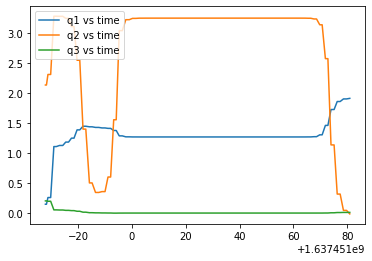

In [138]:
#def PI_Control(A, B):
l1, l2 = 0.5, 0.3
m1, m2, m3 = 2, 2, 2
A = [0.3, 0.3, 0.3]
B = [0.2 , 0.3, 0.4]
l = [l1, l2]
m = [m1, m2, m3]

q1_A, q2_A, q3_A = SCARA_invkin(A, l)
q1_B, q2_B, q3_B = SCARA_invkin(B, l)

q = [q1_A, q2_A, q3_A]
qd = [q1_B, q2_B, q3_B]
print('q = ', q)
print('qd = ', qd)

q_dot = [0, 0, 0]

kp = 100
ki = 50

ode_eqn = ode(dummy_SCARA_invdynamics).set_integrator('vode', nsteps=5, method='bdf')
ode_eqn.set_initial_value([q1_A, 0, q2_A, 0, q3_A, 0], t = 0)
print(ode_eqn.t)
torques = np.array([0, 0, 0])
del_t = 0
loop = 0
q_all1 = []
q_all2 = []
q_all3 = []
q_dot_all1 = []
q_dot_all2 = []
q_dot_all3 = []
time_list = []
while (abs(qd[0] - q[0])>0.001) and (abs(qd[1] - q[1])>0.001) and (abs(qd[2] - q[2])>0.001):
  t = time.time()
  time_list.append(t)

  E = np.array(qd) - np.array(q)
  torques = kp*E + ki*E*del_t

  q_dotdot = SCARA_invdynamics(m, l, q, q_dot, torques)
  q[0], q_dot[0], q[1], q_dot[1], q[2], q_dot[2] = ode_eqn.integrate(ode_eqn.t+1) #DOUBT: ISME TIME KI ARGUMENT ME KYA DAALU?
  #print(q, q_dot)
  q_all1.append(q[0])
  q_all2.append(q[1])
  q_all3.append(q[2])
  q_dot_all1.append(q_dot[0])
  q_dot_all2.append(q_dot[1])
  q_dot_all3.append(q_dot[2])
  

  del_t = time.time() - del_t
  loop = loop + 1
  if loop>100:
    break

plt.plot(time_list, q_all1, label = 'q1 vs time')
plt.plot(time_list, q_all2, label = 'q2 vs time')
plt.plot(time_list, q_all3, label = 'q3 vs time')
plt.legend()

# Implementation of Stanford Dynamics and Control

In [103]:
def Stanford_invkin(p, dimensions):
    #Takes Transformation Matrix T and Stanford Manipulator (with shperical wrist) Dimensions as input and
    #returns joint params for a Stanford Manipulator to achieve the given position (Transformation Matrix)

    l1, l2 = dimensions
    x,y,z = np.array(p)

    #First 3 params
    q1 = np.arctan2(y,x)
    q2 = np.arctan2(z-l1, np.sqrt(x**2 + y**2))
    d3 = np.sqrt(x**2 + y**2 + (z-l1)**2) - l2
    if d3 < 0:
        print('Point out of workspace')
        return None
  
    return q1, q2, d3

def Stanford_forwkin(q, dimensions):
  q1, q2, d3 = q
  l1, l2 = dimensions

  Dh = np.matrix([[q1, l1, 0, np.pi/2],[np.pi/2 + q2, 0, 0, np.pi/2 ],[0, l2 + d3 , 0, 0],[0,0,0,-np.pi/2],[0,0,0,np.pi/2],[0, 0, 0,0]])
  H, J = DH2HnJ(Dh,[2])

  return H[0,-1], H[1, -1], H[2, -1]

In [ ]:
def Stanford_Dmat(m, l):
  m1, m2, m3 = m
  l1, l2 = l
  q1 = sym.Symbol('q1')
  q2 = sym.Symbol('q2')
  q3 = sym.Symbol('q3')
  q1_dot = sym.Symbol('q1_dot')
  q2_dot = sym.Symbol('q2_dot')
  q3_dot = sym.Symbol('q3_dot')
  q1_dotdot = sym.Symbol('q1_dotdot')
  q2_dotdot = sym.Symbol('q2_dotdot')
  q3_dotdot = sym.Symbol('q3_dotdot')

  Jvc1 = np.array([[0, 0, 0],
                   [0, 0, 0], 
                   [0, 0, 0]])
  
  Jvc2 = np.array([[(-l2/2)*sym.sin(q1)*sym.cos(q2), -(l2/2)*sym.cos(q1)*sym.sin(q2), 0],
          [l2/2*sym.cos(q1)*sym.cos(q2), (-l2/2)*sym.sin(q1)*sym.sin(q2), 0],
          [0, l2/2*sym.cos(q2), 0]])
  
  Jvc3 = np.array([[-(l2 + q3/2)*sym.sin(q1)*sym.cos(q2), -(l2 + q3/2)*sym.cos(q1)*sym.sin(q2), sym.cos(q1)*sym.cos(q2)/2],
                  [(l2 + q3/2)*sym.cos(q1)*sym.cos(q2), -(l2 + q3/2)*sym.sin(q1)*sym.sin(q2), sym.sin(q1)*sym.cos(q2)/2],
                  [0, (l2 + q3/2)*sym.cos(q2), sym.sin(q2)/2]])
  
  D = m1*Jvc1.T*Jvc1 + m2*Jvc2.T*Jvc2 + m3*Jvc3.T*Jvc3 #+ Jw1.T*R1*I1*R1.T*Jw1  + Jw2.T*R2*I2*R2.T*Jw2 + Jw3.T*R3*I3*R3.T*Jw3

  return D

#Stanford_Dmat([2, 2, 2], [0.25, 0.25])

In [114]:
def Stanford_dynamic_equation(m, l):
  l1, l2 = l
  m1, m2, m3 = m
  q1 = sym.Symbol('q1')
  q2 = sym.Symbol('q2')
  q3 = sym.Symbol('q3')
  q = np.array([[q1], [q2], [q3]])
  q1_dot = sym.Symbol('q1_dot')
  q2_dot = sym.Symbol('q2_dot')
  q3_dot = sym.Symbol('q3_dot')
  q_dot = np.array([[q1_dot], [q2_dot], [q3_dot]])
  q1_dotdot = sym.Symbol('q1_dotdot')
  q2_dotdot = sym.Symbol('q2_dotdot')
  q3_dotdot = sym.Symbol('q3_dotdot')
  q_dotdot = np.array([[q1_dotdot], [q2_dotdot], [q3_dotdot]])
  g = 9.8

  n = 3

  D = Stanford_Dmat(m, l)
  
  V = m1*g*l1/2 + m2*g*(l1 + l2/2*sym.sin(q1)) + m3*(l1 + (l2 + q3)*sym.sin(q2))

  G = np.array([[sym.diff(V, q1)],
                [sym.diff(V, q2)],
                [sym.diff(V, q3)]])
  
  C = [0]*n

  for k in range(n):
    for j in range(n):
      for i in range(n):
        C[k]  = (sym.diff(D[k][j], q[i][0]) + sym.diff(D[k][i], q[j][0]) - sym.diff(D[i][j], q[k][0]))
        C[k] = C[k]/2

  C = np.array(C)

  dynamic_eqn = sym.Array(D@q_dotdot + C@q_dot + G) #np.matmul(D,q_dotdot) + np.matmul(C,q_dot) + G
  return dynamic_eqn, D, C, G

eqn, D, C, G = Stanford_dynamic_equation([2,2,2],[0.5,0.3])

In [116]:
def Stanford_invdynamics(m, l, q, q_dot, torques):
  q1, q2, q3 = q
  q1_dot, q2_dot, q3_dot = q_dot

  eqn, D, C, G = Stanford_dynamic_equation(m, l)

  eqn_numbers = eqn.subs([('q1',q1), ('q2',q2), ('q3',q3), ('q1_dot', q1_dot), ('q2_dot',q2_dot), ('q3_dot',q3_dot)])
  #print(eqn_numbers)

  D_numbers = np.array([[eqn_numbers[0,0].coeff('q1_dotdot'), eqn_numbers[0,0].coeff('q2_dotdot'), eqn_numbers[0,0].coeff('q3_dotdot')],
                [eqn_numbers[1,0].coeff('q1_dotdot'), eqn_numbers[1,0].coeff('q2_dotdot'), eqn_numbers[1,0].coeff('q3_dotdot')],
                [eqn_numbers[2,0].coeff('q1_dotdot'), eqn_numbers[2,0].coeff('q2_dotdot'), eqn_numbers[2,0].coeff('q3_dotdot')]], dtype = 'float')
  #print(D_numbers)
  
 # M = C@q_dot + G
 # K = eqn_numbers - D@np.array([['q1_dotdot'],['q2_dotdot'],['q3_dotdot']])
  K = np.array([[((eqn_numbers[0,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[1,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[2,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)]])
  #print(K)
  D_inv = np.linalg.inv(D_numbers)
  M = np.array([[torques[0] - K[0,0]],
                [torques[1] - K[1,0]],
                [torques[2] - K[2,0]]])
  #print(D_inv)
  #print(M)
  q_dotdot = np.array(D_inv@M, dtype = 'float')
  #print(q_dotdot)
  return [q_dotdot[0,0], q_dotdot[1,0], q_dotdot[2,0]]

#Stanford_invdynamics([2,2,2], [0.5,0.3], [0.4,0.4,0.4],[0.1,0.1,0.1], [3,4,5])

[22.712393038201352, 7.832843910249302, 38.62575096576823]

In [117]:
def dummy_Stanford_invdynamics(t, y):
  #m = [2, 2, 2]
  #l = [0.5, 0.3, 0.3]
  q1, q2, q3 = y[0], y[2], y[4]
  q1_dot, q2_dot, q3_dot = y[1], y[3], y[5]

  eqn, D, C, G = Stanford_dynamic_equation(m, l)

  eqn_numbers = eqn.subs([('q1',q1), ('q2',q2), ('q3',q3), ('q1_dot', q1_dot), ('q2_dot',q2_dot), ('q3_dot',q3_dot)])
  #print(eqn_numbers)

  D_numbers = np.array([[eqn_numbers[0,0].coeff('q1_dotdot'), eqn_numbers[0,0].coeff('q2_dotdot'), eqn_numbers[0,0].coeff('q3_dotdot')],
                [eqn_numbers[1,0].coeff('q1_dotdot'), eqn_numbers[1,0].coeff('q2_dotdot'), eqn_numbers[1,0].coeff('q3_dotdot')],
                [eqn_numbers[2,0].coeff('q1_dotdot'), eqn_numbers[2,0].coeff('q2_dotdot'), eqn_numbers[2,0].coeff('q3_dotdot')]], dtype = 'float')
  #print(D_numbers)
  
 # M = C@q_dot + G
 # K = eqn_numbers - D@np.array([['q1_dotdot'],['q2_dotdot'],['q3_dotdot']])
  K = np.array([[((eqn_numbers[0,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[1,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)],
                [((eqn_numbers[2,0].coeff('q1_dotdot', 0)).coeff('q2_dotdot', 0)).coeff('q3_dotdot', 0)]])
  #print(K)
  D_inv = np.linalg.inv(D_numbers)
  M = np.array([[torques[0] - K[0,0]],
                [torques[1] - K[1,0]],
                [torques[2] - K[2,0]]])
  #print(D_inv)
  #print(M)
  q_dotdot = np.array(D_inv@M, dtype = 'float')
  #print(q_dotdot)
  return [q_dot[0], q_dotdot[0,0], q_dot[1], q_dotdot[1,0], q_dot[2], q_dotdot[2,0]]

q =  [0.7853981633974483, -0.4405106630046985, 0.16904157598234298]
qd =  [0.982793723247329, -0.2705497629785728, 0.07416573867739418]
0


/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
/usr/local/lib/python3.7/dist-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Repeated error test failures. (Check all input.)
  self.messages.get(istate, unexpected_istate_msg)))


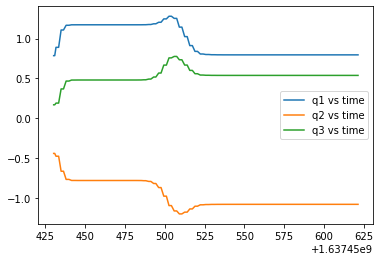

In [118]:
#def PI_Control(A, B):
l1, l2 = 0.5, 0.3
m1, m2, m3 = 2, 2, 2
A = [0.3, 0.3, 0.3]
B = [0.2 , 0.3, 0.4]
l = [l1, l2]
m = [m1, m2, m3]

q1_A, q2_A, q3_A = Stanford_invkin(A, l)
q1_B, q2_B, q3_B = Stanford_invkin(B, l)

q = [q1_A, q2_A, q3_A]
qd = [q1_B, q2_B, q3_B]
print('q = ', q)
print('qd = ', qd)

q_dot = [0, 0, 0]

kp = 100
ki = 50

ode_eqn = ode(dummy_Stanford_invdynamics).set_integrator('vode', nsteps=5, method='bdf')
ode_eqn.set_initial_value([q1_A, 0, q2_A, 0, q3_A, 0], t = 0)
print(ode_eqn.t)
torques = np.array([0, 0, 0])
del_t = 0
loop = 0
q_all1 = []
q_all2 = []
q_all3 = []
q_dot_all1 = []
q_dot_all2 = []
q_dot_all3 = []
time_list = []
while (abs(qd[0] - q[0])>0.001) and (abs(qd[1] - q[1])>0.001) and (abs(qd[2] - q[2])>0.001):
  t = time.time()
  time_list.append(t)

  E = np.array(qd) - np.array(q)
  torques = kp*E + ki*E*del_t

  q_dotdot = Stanford_invdynamics(m, l, q, q_dot, torques)
  q[0], q_dot[0], q[1], q_dot[1], q[2], q_dot[2] = ode_eqn.integrate(ode_eqn.t+1) #DOUBT: ISME TIME KI ARGUMENT ME KYA DAALU?
  #print(q, q_dot)
  q_all1.append(q[0])
  q_all2.append(q[1])
  q_all3.append(q[2])
  q_dot_all1.append(q_dot[0])
  q_dot_all2.append(q_dot[1])
  q_dot_all3.append(q_dot[2])
  

  del_t = time.time() - del_t
  loop = loop + 1
  if loop>100:
    break

plt.plot(time_list, q_all1, label = 'q1 vs time')
plt.plot(time_list, q_all2, label = 'q2 vs time')
plt.plot(time_list, q_all3, label = 'q3 vs time')
plt.legend()